In [36]:
%matplotlib inline
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy
from sklearn.linear_model import LogisticRegression

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X = mnist['data']
y = mnist['target']
print ('x:', X.shape, 'y:', y.shape)

x: (70000, 784) y: (70000,)


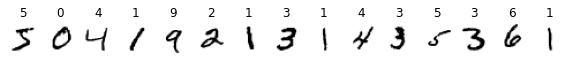

In [109]:
numDigits = 15
plt.figure(figsize=(10, 1))
for idx in range(numDigits):
  plt.subplot(1, numDigits, idx+1)
  digit = X[idx:idx+1].to_numpy()
  image = digit.reshape(28,28)
  plt.imshow(image, cmap="binary")
  plt.title(y[idx])
  plt.axis("off")

plt.show()

In [33]:
X_train, X_test, y_train, y_test = X[:10000], X[60000:], y[:10000].to_numpy(), y[60000:].to_numpy()

In [37]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

In [41]:
lr = LogisticRegression(solver='saga', tol=0.1)
lr.fit(X_train_scaled, y_train)

LogisticRegression(solver='saga', tol=0.1)

In [107]:
numTestDigits = 20
predicted_digits = lr.predict(X_test_scaled[0:numTestDigits])

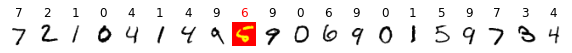

In [108]:
plt.figure(figsize=(10, 1))
for idx in range(numTestDigits):
  plt.subplot(1, numTestDigits, idx+1)
  digit = X_test[idx:idx+1].to_numpy()
  image = digit.reshape(28,28)
  fontColor = 'black'
  colorMap = 'binary'
  if predicted_digits[idx] != y_test[idx] :
    fontColor = 'red'
    colorMap = 'autumn'
  plt.imshow(image, cmap= colorMap)
  plt.title(predicted_digits[idx], fontdict={ 'color': fontColor })
  plt.axis("off")

plt.show()

In [44]:
lr.coef_.shape

(10, 784)

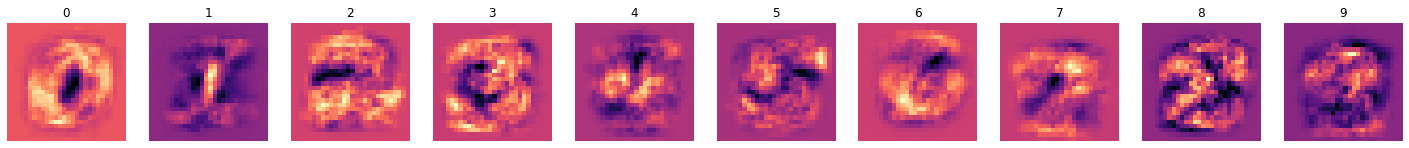

In [75]:
numWeightDigits = 10
plt.figure(figsize=(25, 2.5))
for idx in range(numWeightDigits):
    plt.subplot(1, numWeightDigits, idx+1)
    plt.imshow(lr.coef_[idx].reshape(28, 28),
                  cmap=plt.cm.magma);
    plt.axis('off')
    plt.title(idx);

plt.show()